In [1]:
#import your libraries
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm
import matplotlib.colors as colors

Split your data up

In [5]:
data=requests.get("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050").text
bs=BeautifulSoup(data, 'html.parser')

neightborhoodtable=bs.find('table', class_ = 'wikitable')
nrows=neightborhoodtable.find_all('tr')

ninfo=[]
for row in nrows:
    info=row.text.split('\n')[1:-1]
    ninfo.append(info)
    
ninfo[0:15]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', 'Downtown Toronto', "Queen's Park"],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', 'Etobicoke', 'Islington Avenue'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North']]

Create your dataframe

In [4]:
ninfo[0][-1]='Neighborhood'
n_df=pd.DataFrame(ninfo[1:], columns=ninfo[0])

n_df.head(15)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,Islington Avenue


In [6]:
n_df.shape

(287, 3)

We are going to drop any data that doesn't have a borough assigned

In [7]:
na_boroughs=n_df.index[n_df['Borough']=='Not assigned']
na_neighborhoods=n_df.index[n_df['Neighborhood']=='Not assigned']
na_nb=na_boroughs & na_neighborhoods
n_df.drop(n_df.index[na_boroughs], inplace=True)
n_df.reset_index(drop=True, inplace=True)

n_df.head(15)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Etobicoke,Islington Avenue
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


When we are missing a neigborhood name, we will fill in the borough name

In [8]:
na_neighborhoods=n_df.index[n_df['Neighborhood']=='Not assigned']

for i in na_neighborhoods:
    n_df['Neighborhood'][i] = n_df['Borough'][idx]
    
n_df.head(15)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Etobicoke,Islington Avenue
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


Group by the postcode to allow us to compress the data further

In [9]:
group=n_df.groupby('Postcode')
g_neighborhoods=group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
g_boroughs=group['Borough'].apply(lambda x: set(x).pop())
g_df=pd.DataFrame(list(zip(g_boroughs.index, g_boroughs, g_neighborhoods)))
g_df.columns=['Postcode', 'Borough', 'Neighborhood']

g_df.head(15)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [10]:
g_df.shape

(103, 3)

Time to bring in the latitude and longitude coordinates from the CSV provided in the assignment link

In [14]:
c_df=pd.read_csv('http://cocl.us/Geospatial_data')

c_df.head(15)
c_df.shape

(103, 3)

Join the two tables so that we have postcode, borough, neighborhood, and coordinates all in one table

In [17]:
p_df=g_df.join(c_df.set_index('Postal Code'), on='Postcode')

p_df.shape

(103, 5)

In [18]:
p_df.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


Make a map using folium to show all of our data locations in the table above

In [30]:
import folium
map = folium.Map(location=[43.6,-79.4], zoom_start=11)

for location in p_df.itertuples():
    label='Postal Code:{};  Borough:{};  Neighborhoods:{}'.format(location[1], location[2], location[3])
    label=folium.Popup(label, parse_html=True)    
    folium.CircleMarker([location[-2], location[-1]], radius=1, color='green', fill=True, fill_color='#8f9805', fill_opacity=0.7, parse_html=False).add_to(map) 
    folium.Circle(radius=500, popup=label, location=[location[-2], location[-1]], color='#8f9805', fill=True, fill_color='#8f9805').add_to(map) 
    
map

We are going to create a function to allow us to determine the closest postcode pair

In [84]:
from geopy.distance import great_circle

def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [85]:
coord = p_df[['Latitude', 'Longitude']]
distance, closest_point_index = closest_postcode(coord[:1], coord[~coord.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


Scatter plot of all of the data points with a legend allowing us to see the distance between two points on the top-right corner

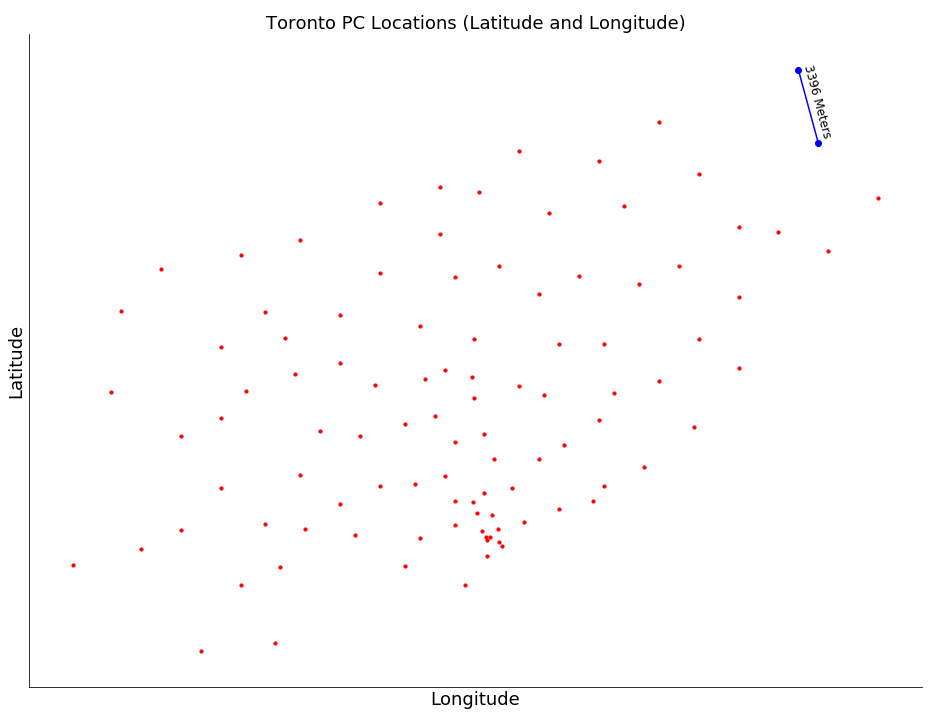

In [40]:
fig=plt.figure(figsize=(16,12))
sp=fig.add_subplot(111)
sp.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
sp.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

sp.annotate('{} Meters'.format(distance), xy=(.859, .912), xycoords='figure fraction', ha='left', va='top', rotation=-75, fontsize=12)
sp.set_yticklabels([])
sp.set_xticklabels([])
sp.set_xticks([])
sp.set_yticks([])
sp.spines['top'].set_color(None)
sp.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('Toronto PC Locations (Latitude and Longitude)', fontsize=18)
sp.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 24})
plt.show()

Add a distance column to the existing dataframe to use as a radius

In [41]:
from math import isnan

for lat, lng, i in zip(p_df['Latitude'], p_df['Longitude'], p_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coord[~coord.index.isin([i])])
    p_df.at[i,'Distance'] = np.int64(distance//2)
    
p_df.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


We are now going to bring in our venues using our foursquare API accounts created during this course (credientials hidden since these are unique for each of these

In [42]:
CLIENT_ID = 'SB5*******'
CLIENT_SECRET = '5UI*********'
VERSION = '********'

In [43]:
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [44]:
first_pc=p_df.iloc[2, :]
url=format_url(first_pc['Latitude'], first_pc['Longitude'], first_pc['Distance'])

In [45]:
def get_venues(url):
    results=requests.get(url).json()
    venues=results['response']['groups'][0]['items']
    return json_normalize(venues)

In [46]:
v_df=get_venues(url)
v_df.head(15)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bc366dab492d13a51b2a860-0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'label': 'display', 'lat': 43.76875171771289...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ba164fdf964a52039b337e3-1,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'label': 'display', 'lat': 43.77134173380578...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c9fdb04542b224bca4201a0-2,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4c9fdb04542b224bca4201a0,4218 Lawrence Avenue East,CA,Scarborough,Canada,NaN,701,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'label': 'display', 'lat': 43.76904597684398...",43.769046,-79.184386,M1E 4X9,ON,Little Caesars Pizza,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b3a9504f964a520646a25e3-3,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'label': 'display', 'lat': 43.77146181777272...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4beca2f9d6e676b0538764d4-4,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",4beca2f9d6e676b0538764d4,"4525 Kingston Road, Unit #H8",CA,Scarborough,Canada,at Collinsgrove Rd.,870,"[4525 Kingston Road, Unit #H8 (at Collinsgrove...","[{'label': 'display', 'lat': 43.77066813, 'lng...",43.770668,-79.184150,M1E 2P1,ON,Booster Juice,0,[]
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-510bd6f1e4b0256d6cc14409-5,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",510bd6f1e4b0256d6cc14409,4551 Kingston Rd.,CA,Toronto,Canada,Lawrence,1020,"[4551 Kingston Rd. (Lawrence), Toronto ON 4551...","[{'label': 'display', 'lat': 43.77231854994461...",43.772319,-79.184900,4551 Kingsto,ON,Sunset Grill,0,[]
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b6074e3f964a5200fe729e3-6,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",4b6074e3f964a5200fe729e3,4410 Kingston Rd,CA,Scarborough,Canada,NaN,526,"[4410 Kingston Rd, Scarborough ON M1E 2N5, Can...","[{'label': 'display', 'lat': 43.76812209738294...",43.768122,-79.190493,M1E 2N5,ON,Swiss Chalet,0,[]
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b06eb1cf964a52005f322e3-7,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",4b06eb1cf964a52005f322e3,255 Morningside Ave,CA,Toronto,Canada,Kingston Rd,777,"[255 Morningside Ave (Kingston Rd), Toronto ON...","[{'label': 'display', 'lat': 43.77037, 'lng': ...",43.770370,-79.186490,M1E 3E6,ON,Starbucks,0,[]
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b75e7bbf964a520992d2ee3-8,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",4b75e7bbf964a520992d2ee3,255 Morningside Ave,CA,Scarborough,Canada,at Kingston Rd.,803,"[255 Morningside Ave (at Kingston Rd.), Scarbo...","[{'label': 'display', 'lat': 43.770282, 'lng':...",43.770282,-79.185012,M1E 3E6,ON,Shoppers Drug Mart,0,[]
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bdcd893462b2d7f13a3113c-9,"[{'id': '5370f356bcbc57f1066c94c2', 'name': 'B...",4bdcd893462b2d7f13a3113c,4479 Kingston Rd Unit 1,CA,Scarboroug

We are going to tidy up the venues dataframe that we just created

In [47]:

def tidy_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    tidy_df = df.loc[:,relevant_columns]
    tidy_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return tidy_df 

v_df = tidy_df(v_df)
v_df.head(15)

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
2,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
3,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
4,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",43.770668,-79.184150,Booster Juice
5,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.772319,-79.184900,Sunset Grill
6,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.768122,-79.190493,Swiss Chalet
7,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.770370,-79.186490,Starbucks
8,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.770282,-79.185012,Shoppers Drug Mart
9,"[{'id': '5370f356bcbc57f1066c94c2', 'name': 'B...",43.769793,-79.187505,The Beer Store


In [48]:
v_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]

Now we want category of the json data

In [49]:
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

v_df['Category'] = v_df.apply(get_category_name, axis=1)
v_df.head(15)

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
2,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
3,Liquor Store,43.771462,-79.184384,LCBO
4,Juice Bar,43.770668,-79.184150,Booster Juice
5,Breakfast Spot,43.772319,-79.184900,Sunset Grill
6,Restaurant,43.768122,-79.190493,Swiss Chalet
7,Coffee Shop,43.770370,-79.186490,Starbucks
8,Pharmacy,43.770282,-79.185012,Shoppers Drug Mart
9,Beer Store,43.769793,-79.187505,The Beer Store


Get all of the venues in each of the postcodes

In [50]:
def get_all_venues(postcodes, lat, lng, radius):
    vlist=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url=format_url(lat, lng, radius)
        results=requests.get(url).json()['response']['groups'][0]['items']
        vlist.append([(postcode, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name'])
            for v in results])
    venues=pd.DataFrame([item for vlist in vlist for item in vlist])
    venues.columns = ['Postcode', 'Postcode Latitude', 'Postcode Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category']
    
    return venues

In [52]:
venues=get_all_venues(p_df['Postcode'], p_df['Latitude'], p_df['Longitude'], p_df['Distance'])

venues.head(15)
venues.shape

(3414, 7)

In [55]:
pdiff = np.setdiff1d(p_df['Postcode'].values,venues['Postcode'].unique())
p_df[p_df['Postcode']==pdiff[0]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


We also want to look at the number of venues in each postcode

In [57]:
vp=venues.groupby('Postcode').count()
vp=pd.DataFrame(list(zip(vp.index, vp['Venue'])), columns=['Postcode', '# of Venues']).set_index('Postcode').join(p_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
vp['Distance'] = np.int64(vp['Distance'])
vp.loc[len(vp.index)] = ['M5E', 0, 111]

vp.head(15)

,Postcode,# of Venues,Distance
0,M1B,37,1698
1,M1C,11,1625
2,M1E,29,1205
3,M1G,4,913
4,M1H,23,913
5,M1J,25,1301
6,M1K,26,1112
7,M1L,29,1052
8,M1M,18,1112
9,M1N,14,1297


In [58]:
vp[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,33.145631
std,25.801432
min,0.000000
25%,14.000000
50%,27.000000
75%,45.000000
max,100.000000


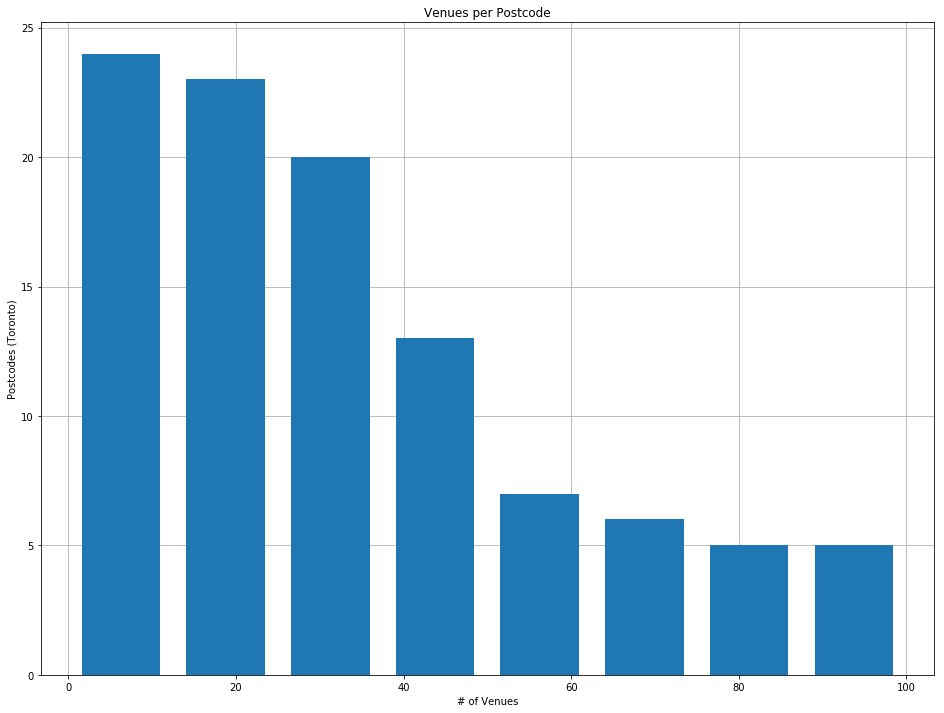

In [62]:
vp['# of Venues'].hist(bins=8, figsize=(16,12),zorder=2, rwidth=.75)
plt.xlabel('# of Venues')
plt.ylabel('Postcodes (Toronto)')
plt.title('Venues per Postcode')

plt.show()

On top of venues in each postcode, let's take a look at density distribution of venues in each postcode

In [63]:
dvp=venues.groupby('Postcode').count()
dvp=pd.DataFrame(list(zip(dvp.index, dvp['Venue'])), columns=['Postcode', 'Density']).set_index('Postcode').join(p_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
dvp['Density'] = np.int64(dvp['Density']/(dvp['Distance']/1000))
dvp.loc[len(vp.index)] = ['M5E', 0, 111]

dvp.head(15)

,Postcode,Density,Distance
0,M1B,21,1698.0
1,M1C,6,1625.0
2,M1E,24,1205.0
3,M1G,4,913.0
4,M1H,25,913.0
5,M1J,19,1301.0
6,M1K,23,1112.0
7,M1L,27,1052.0
8,M1M,16,1112.0
9,M1N,10,1297.0


In [64]:
dvp[['Density']].describe()

,Density
count,103.000000
mean,46.980583
std,48.355096
min,0.000000
25%,15.500000
50%,31.000000
75%,63.000000
max,271.000000


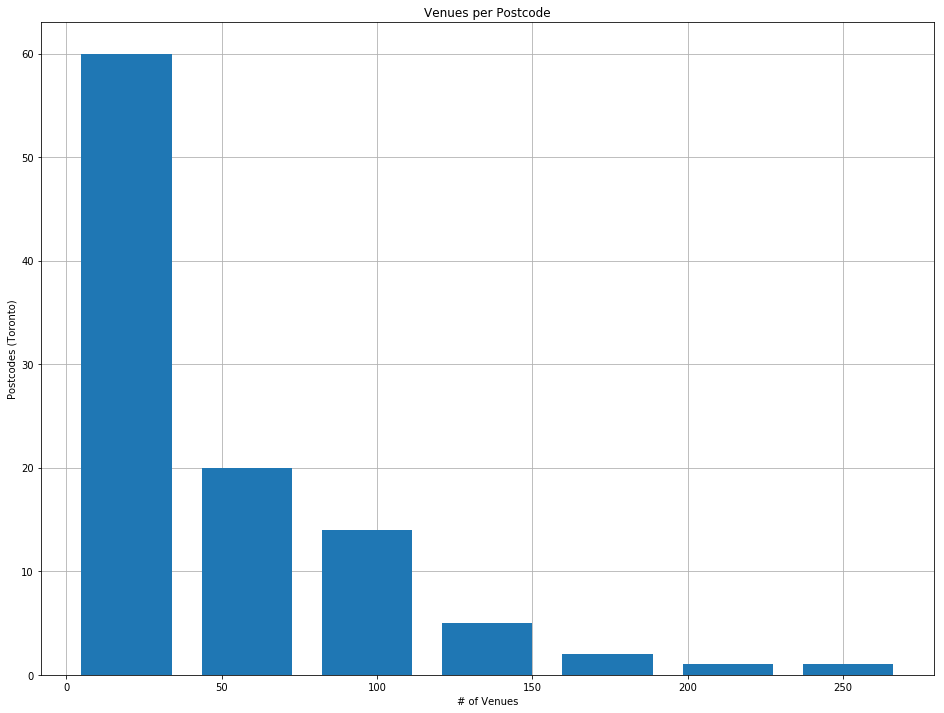

In [65]:
dvp['Density'].hist(bins=7, figsize=(16,12),zorder=2, rwidth=0.75)
plt.xlabel('# of Venues')
plt.ylabel('Postcodes (Toronto)')
plt.title('Venues per Postcode')

plt.show()

Finally, after collecting and organizing all of this data, it is time to cluster all of it. I chose to use k-means clustering for this project

In [67]:
from sklearn import metrics
from scipy.spatial.distance import cdist

dis=[]
K=range(1,15)
for k in K:
    kmeans=KMeans(init="k-means++", n_clusters=k, n_init=12)
    kmeans.fit(dvp['Density'].values.reshape(-1, 1))
    dis.append(sum(np.min(cdist(dvp['Density'].values.reshape(-1, 1), kmeans.cluster_centers_, 'euclidean'), axis=1)) / dvp['Density'].shape[0])

In [69]:
ncluster=5
kmeans=KMeans(init= "k-means++", n_clusters=ncluster, n_init = 12)
kmeans.fit(dvp['Density'].values.reshape(-1, 1))
labels=kmeans.labels_

print(labels)

[1 1 1 1 1 1 1 4 1 1 4 4 4 4 4 4 1 1 4 1 1 1 0 4 4 4 1 4 4 4 1 1 1 1 1 1 1
 0 0 4 4 3 4 3 1 1 4 0 1 0 1 0 2 0 2 3 0 3 2 0 3 4 1 1 4 0 2 4 0 0 4 4 1 1
 4 4 3 0 1 1 4 0 0 0 1 4 4 4 4 4 1 4 1 1 1 1 1 1 1 1 1 1 1]


In [70]:
dvp['Cluster']=kmeans.labels_
dvp.head(15)

,Postcode,Density,Distance,Cluster
0,M1B,21,1698.0,1
1,M1C,6,1625.0,1
2,M1E,24,1205.0,1
3,M1G,4,913.0,1
4,M1H,25,913.0,1
5,M1J,19,1301.0,1
6,M1K,23,1112.0,1
7,M1L,27,1052.0,4
8,M1M,16,1112.0,1
9,M1N,10,1297.0,1


After landing on k=5, we needed to find the centroids of each cluster

In [71]:
centroid=np.int64(round(dvp.groupby('Cluster').mean()['Density']))
f=dvp.groupby('Cluster').count()['Postcode']
cinfo=pd.DataFrame([np.arange(0,5), centroid, f], index=['Cluster', 'Centroid','Postcodes']).T
cinfo.sort_values('Centroid', inplace=True)
cinfo.reset_index(drop=True, inplace=True)

cinfo

,Cluster,Centroid,Postcodes
0,1,14,45
1,4,39,32
2,0,84,16
3,3,126,6
4,2,217,4


We determine that the 5 clusters range from tier 1 through tier 5. Tier 1 being the lowest density and tier 5 being the highest density. The centroid is specified in the graph below.

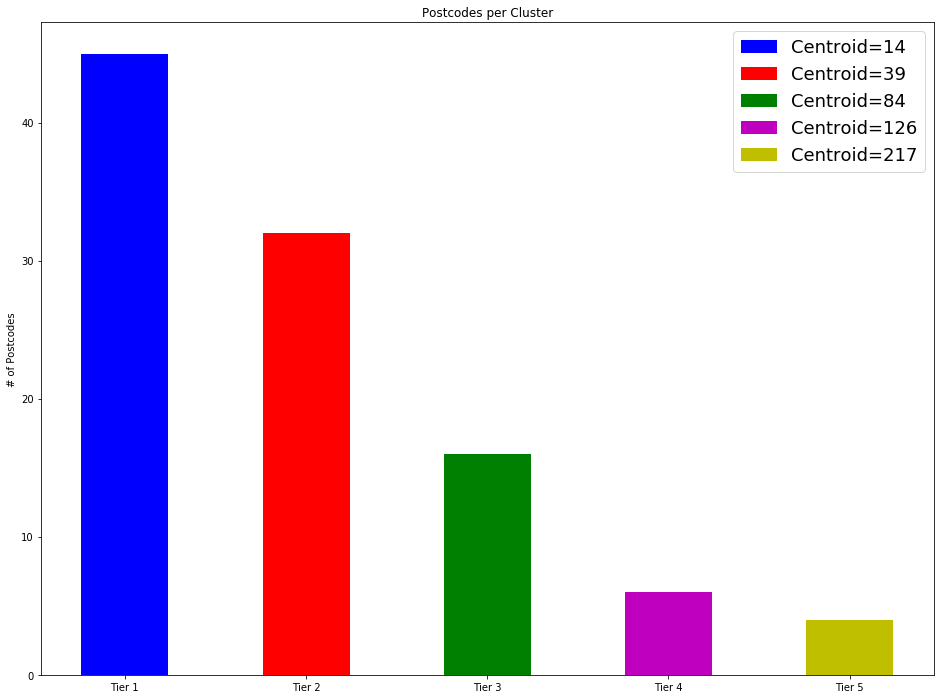

In [86]:
fig, ax=plt.subplots(figsize=(16,12))
tiers= ['Tier 1','Tier 2','Tier 3','Tier 4','Tier 5']
colors=['b','r','g','m','y']
legend=[]

for id, cluster in enumerate(tiers):
    legend.append('Centroid={}'.format(cinfo['Centroid'][id]))
    bar=ax.bar(cluster, cinfo['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('# of Postcodes')
ax.set_title('Postcodes per Cluster')
plt.legend(legend, fontsize=18)

plt.show()

Here is the final map with the colors matching the colors on the bar graph above

In [83]:
p_df = pd.concat([p_df[:56],p_df[57:],p_df[56:57]])
p_df['Cluster'] = kmeans.labels_
colors=['blue','red','green','magenta','yellow']
cvalues = cinfo['Cluster']

map=folium.Map(location=[43.6,-79.4], zoom_start=11)

for location in p_df.itertuples():
    cindex = cvalues.index[cvalues==location[-1]][0]
    label='Postal Code:{};  Borough:{};  Neighborhoods:{};{}'.format(location[1], location[2], location[3], cluster[cindex])
    label=folium.Popup(label, parse_html=True)    
    folium.Circle(radius=location[-2],popup=label,location=[location[-4], location[-3]],color=None,fill=True,fill_opacity=0.4,fill_color=colors[cindex]).add_to(map) 

map